<a href="https://www.kaggle.com/code/giuliacaa/find-the-flag?scriptVersionId=141383268" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Find the flag - Decision Tree Classifier

In this project, I’ll use decision trees to try to predict the continent of flags based on several of these features.

I’ll explore which features are the best to use and the best way to create your decision tree.

The original data set is available at the UCI Machine Learning Repository: 
https://archive.ics.uci.edu/ml/datasets/Flags

# Import modules and read data

In [1]:
import seaborn as sns
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree

import matplotlib.pyplot as plt

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
# Read data into df
cols = ['name','landmass','zone', 'area', 'population', 'language','religion','bars','stripes','colours',
'red','green','blue','gold','white','black','orange','mainhue','circles',
'crosses','saltires','quarters','sunstars','crescent','triangle','icon','animate','text','topleft','botright']

df= pd.read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/flags/flag.data", names = cols)

In [3]:
print(df.shape)
df.head()

(194, 30)


,name,landmass,zone,area,population,language,religion,bars,stripes,colours,...,saltires,quarters,sunstars,crescent,triangle,icon,animate,text,topleft,botright
0,Afghanistan,5,1,648,16,10,2,0,3,5,...,0,0,1,0,0,1,0,0,black,green
1,Albania,3,1,29,3,6,6,0,0,3,...,0,0,1,0,0,0,1,0,red,red
2,Algeria,4,1,2388,20,8,2,2,0,3,...,0,0,1,1,0,0,0,0,green,white
3,American-Samoa,6,3,0,0,1,1,0,0,5,...,0,0,0,0,1,1,1,0,blue,red
4,Andorra,3,1,0,0,6,0,3,0,3,...,0,0,0,0,0,0,0,0,blue,red


# Explore the data

In [4]:
df.columns

Index(['name', 'landmass', 'zone', 'area', 'population', 'language',
       'religion', 'bars', 'stripes', 'colours', 'red', 'green', 'blue',
       'gold', 'white', 'black', 'orange', 'mainhue', 'circles', 'crosses',
       'saltires', 'quarters', 'sunstars', 'crescent', 'triangle', 'icon',
       'animate', 'text', 'topleft', 'botright'],
      dtype='object')

Columns:
- `name`: Name of the country concerned
- `landmass`: 1=N.America, 2=S.America, 3=Europe, 4=Africa, 5=Asia, 6=Oceania
- `bars`: Number of vertical bars in the flag
- `stripes`: Number of horizontal stripes in the flag
- `colours`: Number of different colours in the flag
- `red`: 0 if red absent, 1 if red present in the flag
…

- `mainhue`: predominant colour in the flag (tie-breaks decided by taking the topmost hue, if that fails then the most central hue, and if that fails the leftmost hue)
- `circles`: Number of circles in the flag
- `crosses`: Number of (upright) crosses
- `saltires`: Number of diagonal crosses
- `quarters`: Number of quartered sections
- `sunstars`: Number of sun or star symbols

I first want to understand the distribution of flags by continent.

In [5]:
# Count amount of countries per continent (landmass)
df.groupby('landmass').name.count()

landmass
1    31
2    17
3    35
4    52
5    39
6    20
Name: name, dtype: int64

In [6]:
# I'll only focus on two continents, Europe and Oceania
df_36 = df[(df['landmass'] == 3) | (df['landmass'] == 6)]
df_36.landmass.value_counts()

3    35
6    20
Name: landmass, dtype: int64

In [7]:
#I'll use the following variables as predictors
var = [ 'red', 'green', 'blue','gold', 'white', 'black', 'orange', \
       'mainhue','bars','stripes', 'circles','crosses', 'saltires',\
       'quarters','sunstars','triangle','animate']

# print the average values of each var for the two continents
df_36.groupby('landmass')[var].mean().T

/tmp/ipykernel_20/2131585610.py:7: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_36.groupby('landmass')[var].mean().T


landmass,3,6
red,0.828571,0.80
green,0.200000,0.20
blue,0.514286,0.80
gold,0.428571,0.60
white,0.771429,0.95
black,0.171429,0.15
orange,0.057143,0.15
bars,0.628571,0.00
stripes,1.285714,0.40
circles,0.028571,0.15


In [8]:
# inspect data type for the predictors (var)
df_36[var].dtypes

red          int64
green        int64
blue         int64
gold         int64
white        int64
black        int64
orange       int64
mainhue     object
bars         int64
stripes      int64
circles      int64
crosses      int64
saltires     int64
quarters     int64
sunstars     int64
triangle     int64
animate      int64
dtype: object

`mainhue` is a categorical value, so I need to convert it using dummy variables.

In [9]:
# Create predictors df
predictors = pd.get_dummies(df_36[var])
predictors.head()

,red,green,blue,gold,white,black,orange,bars,stripes,circles,...,quarters,sunstars,triangle,animate,mainhue_black,mainhue_blue,mainhue_gold,mainhue_green,mainhue_red,mainhue_white
1,1,0,0,1,0,1,0,0,0,0,...,0,1,0,1,0,0,0,0,1,0
3,1,0,1,1,1,0,1,0,0,0,...,0,0,1,1,0,1,0,0,0,0
4,1,0,1,1,0,0,0,3,0,0,...,0,0,0,0,0,0,1,0,0,0
10,1,0,1,0,1,0,0,0,0,0,...,1,6,0,0,0,1,0,0,0,0
11,1,0,0,0,1,0,0,0,3,0,...,0,0,0,0,0,0,0,0,1,0


In [10]:
# Create labels df
labels = df_36['landmass']
labels.head()

1     3
3     6
4     3
10    6
11    3
Name: landmass, dtype: int64

# Build and optimize the model

In [11]:
# Split the data
train_pred, test_pred, train_labels, test_labels = train_test_split(predictors, labels, random_state=1, test_size=0.4)

In [12]:
# score the model without optimization
dt = DecisionTreeClassifier()
dt.fit(train_pred, train_labels)

score_no_params = dt.score(test_pred, test_labels)

print('Score without optimization: ' + str(score_no_params))

Score without optimization: 0.5909090909090909


In [13]:
# Test the performance of the tree over a range of max_depth.
depths = range(1, 21)   #range of max_depth 1-20
acc_depth = []          #list os scores for each depth

for i in depths:
    dt = DecisionTreeClassifier(max_depth=i, random_state = 1)
    dt.fit(train_pred, train_labels)
    acc_depth.append(dt.score(test_pred, test_labels))

scores = pd.DataFrame(acc_depth,
                      index=range(1, 21), 
                      columns = ['score'])

best_max_depth = scores.score.idxmax()

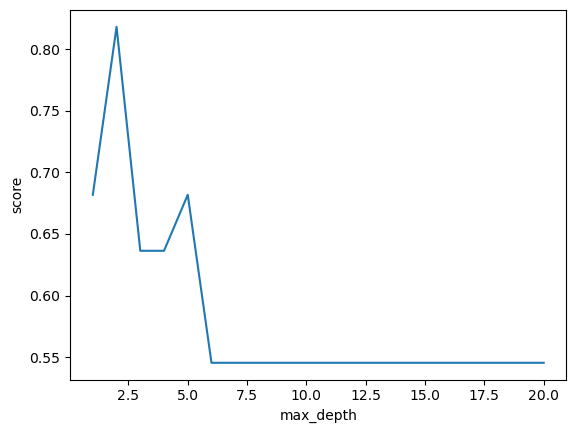

In [14]:
# plot scores vs depth
plt.plot(scores.index, scores.score)
plt.xlabel('max_depth')
plt.ylabel('score')
plt.show()

Score with depth optimized: 0.6818181818181818


[Text(0.5, 0.8333333333333334, 'mainhue_blue <= 0.5\ngini = 0.422\nsamples = 33\nvalue = [23, 10]\nclass = Europe'),
 Text(0.25, 0.5, 'circles <= 0.5\ngini = 0.219\nsamples = 24\nvalue = [21, 3]\nclass = Europe'),
 Text(0.125, 0.16666666666666666, 'gini = 0.159\nsamples = 23\nvalue = [21, 2]\nclass = Europe'),
 Text(0.375, 0.16666666666666666, 'gini = 0.0\nsamples = 1\nvalue = [0, 1]\nclass = Oceania'),
 Text(0.75, 0.5, 'white <= 0.5\ngini = 0.346\nsamples = 9\nvalue = [2, 7]\nclass = Oceania'),
 Text(0.625, 0.16666666666666666, 'gini = 0.0\nsamples = 1\nvalue = [1, 0]\nclass = Europe'),
 Text(0.875, 0.16666666666666666, 'gini = 0.219\nsamples = 8\nvalue = [1, 7]\nclass = Oceania')]

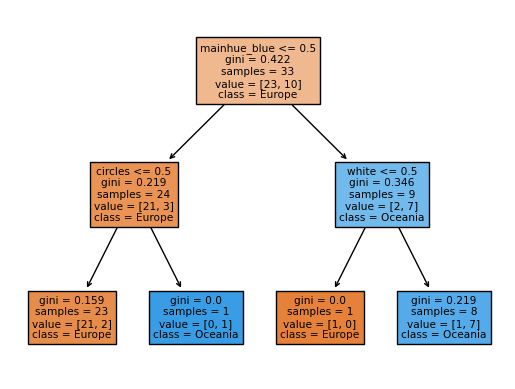

In [15]:
# fit the decision tree using the best max_depth
dt = DecisionTreeClassifier(max_depth=best_max_depth)
dt.fit(train_pred, train_labels)

score_optimized_depth = dt.score(test_pred, test_labels)

print('Score with depth optimized: ' + str(score_optimized_depth))

#plot the tree
tree.plot_tree(dt,
               feature_names = train_pred.columns,
               class_names = ['Europe', 'Oceania'],
               filled = True)

In [16]:
# Test which ccp_alpha parameter is best, same way as above
ccp = np.logspace(-3, 0, num=20)
acc_ccp = []

for i in ccp:
    dt = DecisionTreeClassifier(max_depth=best_max_depth, random_state = 1, ccp_alpha=i)
    dt.fit(train_pred, train_labels)
    acc_ccp.append(dt.score(test_pred, test_labels))

scores = pd.DataFrame(zip(ccp, acc_ccp), columns = ['ccp_alpha', 'score'])

best_ccp = scores.sort_values(by='score', ascending=False).ccp_alpha[0]
best_ccp

0.001

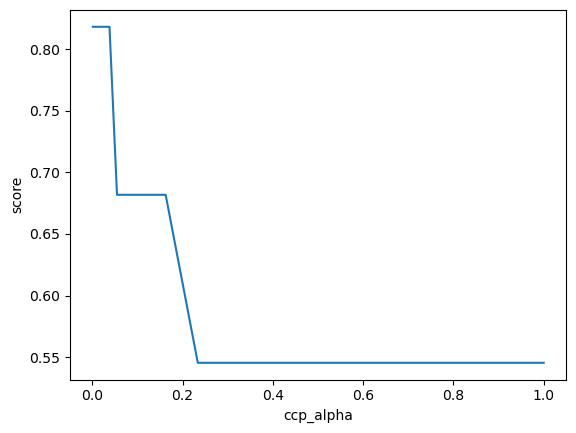

In [17]:
# plot scores vs ccp
plt.plot(scores.ccp_alpha, scores.score)
plt.xlabel('ccp_alpha')
plt.ylabel('score')
plt.show()

[Text(0.5, 0.8333333333333334, 'mainhue_blue <= 0.5\ngini = 0.422\nsamples = 33\nvalue = [23, 10]\nclass = Europe'),
 Text(0.25, 0.5, 'circles <= 0.5\ngini = 0.219\nsamples = 24\nvalue = [21, 3]\nclass = Europe'),
 Text(0.125, 0.16666666666666666, 'gini = 0.159\nsamples = 23\nvalue = [21, 2]\nclass = Europe'),
 Text(0.375, 0.16666666666666666, 'gini = 0.0\nsamples = 1\nvalue = [0, 1]\nclass = Oceania'),
 Text(0.75, 0.5, 'white <= 0.5\ngini = 0.346\nsamples = 9\nvalue = [2, 7]\nclass = Oceania'),
 Text(0.625, 0.16666666666666666, 'gini = 0.0\nsamples = 1\nvalue = [1, 0]\nclass = Europe'),
 Text(0.875, 0.16666666666666666, 'gini = 0.219\nsamples = 8\nvalue = [1, 7]\nclass = Oceania')]

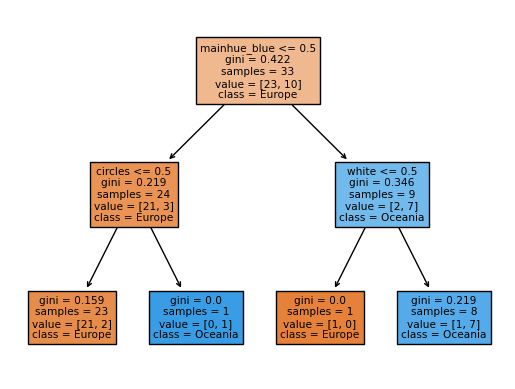

In [18]:
# fit the decision tree using the best max_depth and ccp_alpha
dt = DecisionTreeClassifier(max_depth=best_max_depth, ccp_alpha=best_ccp)
dt.fit(train_pred, train_labels)

#plot the tree
tree.plot_tree(dt,
               feature_names = train_pred.columns,
               class_names = ['Europe', 'Oceania'],
               filled = True)

In [19]:
score_optimized_tree = dt.score(test_pred, test_labels)
print('Score with optimization: ' + str(score_optimized_tree))

Score with optimization: 0.6818181818181818
